In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

## Consideration before starting

1. Outliers are treated in `Outlier Removal file`
2. Avg time to Travel 1Km in NYC is around 10-15 mins, because we don't want our driver to travel alot, hence we will divide the map so that most of cluster or region form are approx 1miles or (10-15 mins) away from each other.
3. also we don't want a lot of region, that don't make any sense anymore, also we don't want the region to be too far that can lead to more fuel consumption of driver and take more time to reach there.

#### For Dividing map into clusters, we will use Mini Batch k-means, why?
- Although Mini Batch K-means is stochastic is nature, but it is faster.
- We can use DBSCAN for clustering but it do not have partial_fit method, and hence I can't load my entire dataset, and feed to DBSCAN directly.
- One more advantage of using K-means is that we will use the centroid value of it while calculating the distance.

In [ ]:
# creating a function that returns the text parser over the file

def read_csv():
    return pd.read_csv('../data/interim/pickup_coordinate.csv', chunksize=100000)

In [ ]:
# taking a sample of data and plotting it 

all_samples = []

for df in read_csv():
    all_samples.append(df.sample(500))

sample_df = pd.concat(all_samples, axis=0)

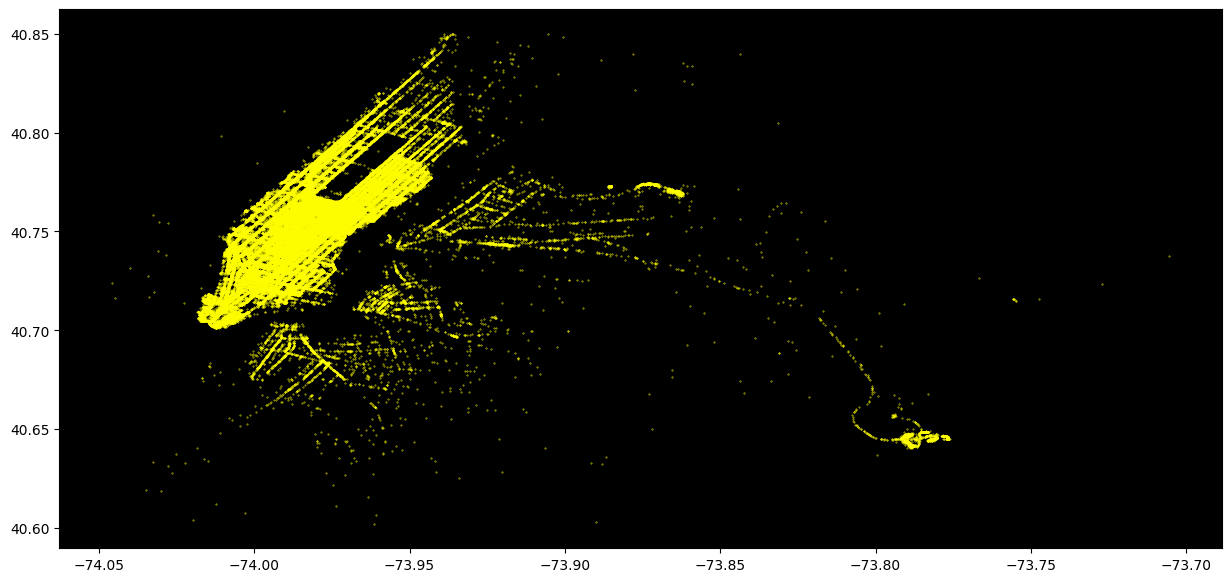

In [13]:
fig, ax = plt.subplots(1,1, figsize=(15,7))

ax.set_facecolor('k')
plt.scatter(sample_df.iloc[:, 1], sample_df.iloc[:, 0], color='yellow', s=0.1)

In [ ]:
# scaling the sample df

scaler = StandardScaler()
scaler.set_output(transform='pandas')

scaled_sample_df = scaler.fit_transform(sample_df)

In [12]:
scaled_sample_df

,pickup_latitude,pickup_longitude
82152,0.016622,-0.224372
66881,-1.057676,-0.809044
40120,0.343551,-0.468313
91927,-0.418537,-0.769872
55521,1.876981,0.155116
...,...,...
33227472,-0.667520,-0.793707
33206336,0.471127,-0.186858
33228893,-0.859584,-0.302715
33208528,-1.063144,-0.628938


In [ ]:
# creating a scaler on entire dataset

df_reader = read_csv()

scaler = StandardScaler()

for chunk in df_reader:
    scaler.partial_fit(chunk)

In [16]:
def haversine_distance(lat1:float, lon1:float, lat2:float, lon2:float):
    """
    Calculate haversine distances between two points given their latitude and
    longitude coordinates
    """
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(
        dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    
    earth_radius = 3958.8
    distance = earth_radius * c
    return distance

In [ ]:
# for determining which k value will be best for our dataset.
# best will be decided by, higher number of clusters that are closer to each other (1-1.5 miles)

def select_optimum_k(k_values):
    for k in k_values:
        df_reader = read_csv()
        kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42)

        for chunk in df_reader:
            scaled_chunk = scaler.fit_transform(chunk)
            kmeans.partial_fit(scaled_chunk)
        
        centroids = scaler.inverse_transform(kmeans.cluster_centers_)

        all_distances = []
        for i in centroids:
            distances = []
            for j in centroids:
                distance = haversine_distance(i[0], i[1], j[0], j[1])
                distances.append(distance)
            all_distances.append(distances)
        
        
        all_distances = np.array(all_distances)
        sorted_distances = np.sort(all_distances, axis=-1)
        region_count = 8

        selected_distances = sorted_distances[:, 1: region_count+1]

        avg_distances = np.mean(selected_distances, axis=-1)

        counter = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).sum()

        percentage = ((avg_distances >= 1.0) & (avg_distances <= 1.5)).mean()

        print(f'For {k} clusters, the number regions that fits the criteria are {counter} and is {round(percentage*100,2)}% regions of total')

In [ ]:
# we can clearly see that, on our dataset, 30 clusters are performing best, 13 clusters which is 43% of regions
# have distance between 1-1.5 miles

k_values = range(10,100,10)

select_optimum_k(k_values)

For 10 clusters, the number regions that fits the criteria are 0 and is 0.0% regions of total
For 20 clusters, the number regions that fits the criteria are 5 and is 25.0% regions of total
For 30 clusters, the number regions that fits the criteria are 13 and is 43.33% regions of total
For 40 clusters, the number regions that fits the criteria are 11 and is 27.5% regions of total
For 50 clusters, the number regions that fits the criteria are 6 and is 12.0% regions of total
For 60 clusters, the number regions that fits the criteria are 4 and is 6.67% regions of total
For 70 clusters, the number regions that fits the criteria are 6 and is 8.57% regions of total
For 80 clusters, the number regions that fits the criteria are 10 and is 12.5% regions of total
For 90 clusters, the number regions that fits the criteria are 11 and is 12.22% regions of total


In [43]:
kmeans = MiniBatchKMeans(n_clusters=30, n_init=10, random_state=42)

for chunk in read_csv():
    scaled_chunk = scaler.fit_transform(chunk)
    kmeans.partial_fit(scaled_chunk)

In [ ]:
# calculating the predictions 

sample_predictions = kmeans.predict(scaled_sample_df)

c:\Users\aksha\OneDrive\Desktop\Urban Fleet Equilibrium Engine via Dynamic Geo-Clustering\penv\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning:

X has feature names, but MiniBatchKMeans was fitted without feature names



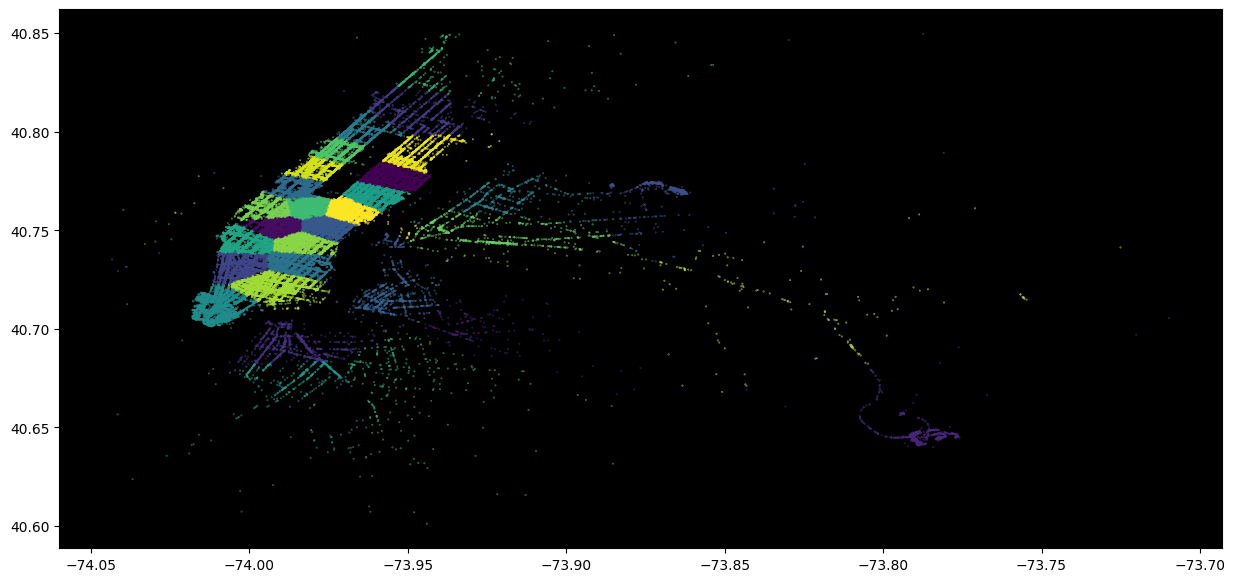

In [ ]:
# visualizing it

fig, ax = plt.subplots(1,1, figsize=(15,7))

ax.set_facecolor('k')
plt.scatter(sample_df.iloc[:, 1], sample_df.iloc[:, 0], c=sample_predictions, s=0.1)